# Table of Contents :
* [1. Problem Introduction](#section1)
* [2. Data preprocessing](#section2)
* [3. Modelling](#section3)
    - [SVC](#section31)
    - [Transfer learning with VGG16](#section32)
  




<a id="section1"></a>
## Introduction :
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">We are given a dataset about various books category and their picture. 
We will classification book into right categories</p>

In [86]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2


<a id="section2"></a>
## Data Preprocessing :


In [87]:
images = []
targets =[]
flatten_img = []

In [88]:
DATADIR = './images'
CATS = ["Sách_Giáo_Khoa_Cấp_1","Sách_Giáo_Khoa_Cấp_2","Sách_Giáo_Khoa_Cấp_3"]
for cat in CATS:
    class_num = CATS.index(cat)
    path = os.path.join(DATADIR, cat)
    #print(path)
    for item in os.listdir(path):
        img =cv2.imread(os.path.join(path, item), 1)
        #print(img.shape)
        # plt.imshow(img)
        # plt.show()
        #print(item)
        flatten_img.append(img.flatten())
        images.append(img)
        targets.append(class_num)

In [89]:
images_np = np.array(images, dtype=np.float32)
targets_np = np.array(targets, dtype=np.float32)
flatten_img_np =  np.array(flatten_img, dtype=np.float32)
print(images_np.shape)
print(targets_np.shape)
print(flatten_img_np.shape)

(100, 280, 200, 3)
(100,)
(100, 168000)


<a id="section3"></a>
## Modelling :


In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(flatten_img_np, targets, test_size=0.2, random_state=42)

In [91]:
y_train = np.array(y_train)
y_test = np.array(y_test)

<a id="section31"></a>
## SVC :


In [92]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV,cross_val_score

param_grid = [
    {'C':[1,10,100,1000], 'kernel':["linear"]},
    {'C':[1,10,100,1000], 'gamma':[0.001, 0.0001] ,'kernel':["rbf"]}
]
svc = svm.SVC()
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             scoring='accuracy')

In [93]:
results = grid_search.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(mean_score, params)

0.5 {'C': 1, 'kernel': 'linear'}
0.5 {'C': 10, 'kernel': 'linear'}
0.5 {'C': 100, 'kernel': 'linear'}
0.5 {'C': 1000, 'kernel': 'linear'}
0.4375 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.4375 {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.4375 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.4375 {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.4375 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.4375 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.4375 {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.4375 {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [94]:
from sklearn.metrics import accuracy_score

svc_best =  grid_search.best_estimator_

cv_scrore = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
print(cv_scrore)
print(np.mean(cv_scrore))


[0.5625 0.625  0.4375 0.4375 0.4375]
0.5


<a id="section32"></a>
## Transfer learning :

In [95]:
# using pretrain model
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from  tensorflow.keras.utils import to_categorical
tf.keras.utils.set_random_seed(42)


2023-06-23 20:06:34.924395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [96]:
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(images_np, targets, test_size=0.1, random_state=42)
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(X_train_img, y_train_img, test_size=0.2, random_state=42)

y_train_img = to_categorical(y_train_img, 3)
y_val_img = to_categorical(y_val_img, 3)
y_test_img = to_categorical(y_test_img, 3)
y_train_img = np.array(y_train_img)
y_test_img = np.array(y_test_img)
y_val_img = np.array(y_val_img)

In [97]:
print(type(X_train_img), type((y_train_img)))
print(type(X_test_img), type((y_test_img)))
print(X_train_img.shape, y_train_img.shape, X_test_img.shape, y_test_img.shape, X_val_img.shape, y_val_img.shape)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(72, 280, 200, 3) (72, 3) (10, 280, 200, 3) (10, 3) (18, 280, 200, 3) (18, 3)


In [102]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(280,200, 3), classes=3)
for layer in base_model.layers:
    layer.trainable = False

transfer_model = Sequential()
transfer_model.add(base_model)

transfer_model.add(Flatten())

transfer_model.add(Dense(256,activation="relu"))
transfer_model.add(Dense(len(CATS),activation="softmax"))

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history  =  transfer_model.fit(X_train_img, y_train_img,batch_size=16, epochs=2, validation_data=(X_val_img, y_val_img))

# score = transfer_model.evaluate(X_test_img, y_test_img, verbose=0)
# print('train loss:', score[0])
# print('test accuracy:', score[1])




Epoch 1/2
5/5 [==============================] - 14s 3s/step - loss: 43.9866 - accuracy: 0.4444 - val_loss: 22.5316 - val_accuracy: 0.5556
Epoch 2/2
5/5 [==============================] - 13s 3s/step - loss: 7.7088 - accuracy: 0.8194 - val_loss: 7.4557 - val_accuracy: 0.5556


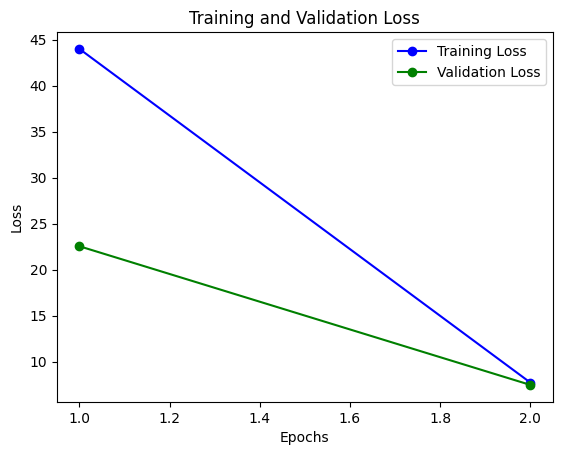

In [103]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot of the loss curves
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [104]:
loss, accuracy = transfer_model.evaluate(X_test_img, y_test_img)
print(accuracy)

1/1 [==============================] - 1s 1s/step - loss: 8.0905 - accuracy: 0.8000
0.800000011920929
